In [1]:
import numpy as np
import pandas as pd
from glob import glob
from scipy import stats
from scipy.stats import rankdata
from pathlib import Path
import matplotlib.pyplot as plt

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

optuna.logging.set_verbosity(optuna.logging.ERROR)

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric

In [2]:
SUB_PATH =  Path("../data/subs/blend")

***
## load data

In [3]:
# lgbm-dart

files = sorted(glob("../data/oof/lgbm-dart-bce-dsv06/oof-*.csv"))[:3]
display(files)
dfs = [pd.read_csv(fn) for fn in files]
df1 = dfs[0][["target"]].copy()

for i,_df in enumerate(dfs):
    df1[f"pred{i}"] = _df["pred"].values
    
df1

['../data/oof/lgbm-dart-bce-dsv06/oof-cv0.csv',
 '../data/oof/lgbm-dart-bce-dsv06/oof-cv1.csv',
 '../data/oof/lgbm-dart-bce-dsv06/oof-cv2.csv']

target     pred0     pred1     pred2
0            0  0.000095  0.000128  0.000138
1            0  0.000804  0.001130  0.000724
2            0  0.000869  0.000912  0.000853
3            0  0.004440  0.003948  0.002493
4            0  0.000796  0.001086  0.001268
...        ...       ...       ...       ...
458908       0  0.002392  0.003892  0.003660
458909       0  0.030060  0.025925  0.040111
458910       0  0.001829  0.001508  0.001151
458911       1  0.117354  0.088613  0.100317
458912       0  0.002464  0.002406  0.002389

[458913 rows x 4 columns]

In [4]:
# lgbm-dart-xtree

files = sorted(glob("../data/oof/lgbm-dart-xtree-bce-dsv06/oof-*.csv"))[:3]
display(files)
dfs = [pd.read_csv(fn) for fn in files]
df2 = dfs[0][["target"]].copy()

for i,_df in enumerate(dfs):
    df2[f"pred{i}"] = _df["pred"].values
    
df2

['../data/oof/lgbm-dart-xtree-bce-dsv06/oof-cv0.csv',
 '../data/oof/lgbm-dart-xtree-bce-dsv06/oof-cv1.csv',
 '../data/oof/lgbm-dart-xtree-bce-dsv06/oof-cv2.csv']

target     pred0     pred1     pred2
0            0  0.000189  0.000166  0.000201
1            0  0.001057  0.001005  0.001008
2            0  0.000947  0.000614  0.000748
3            0  0.003632  0.004046  0.004359
4            0  0.001679  0.001893  0.001689
...        ...       ...       ...       ...
458908       0  0.003449  0.003692  0.004880
458909       0  0.033513  0.031128  0.033232
458910       0  0.002019  0.002351  0.001553
458911       1  0.114709  0.091910  0.105601
458912       0  0.002297  0.001866  0.002443

[458913 rows x 4 columns]

In [5]:
# lgbm-dart-linear

#files = sorted(glob("../data/oof/lgbm-dart-linear-bce-dsv02/oof-*.csv"))[:3]
#display(files)
#dfs = [pd.read_csv(fn) for fn in files]
#df3 = dfs[0][["target"]].copy()

#for i,_df in enumerate(dfs):
#    df3[f"pred{i}"] = _df["pred"].values
    
#df3

In [6]:
# xgboost

files = sorted(glob("../data/oof/xgboost-dsv06/oof-*.csv"))[:3]
display(files)
dfs = [pd.read_csv(fn) for fn in files]
df4 = dfs[0][["target"]].copy()

for i,_df in enumerate(dfs):
    df4[f"pred{i}"] = _df["pred"].values
df4

['../data/oof/xgboost-dsv06/oof-cv0.csv',
 '../data/oof/xgboost-dsv06/oof-cv1.csv',
 '../data/oof/xgboost-dsv06/oof-cv2.csv']

target     pred0     pred1     pred2
0            0  0.000096  0.000073  0.000128
1            0  0.000788  0.000974  0.001067
2            0  0.000740  0.000771  0.000852
3            0  0.002451  0.003942  0.002418
4            0  0.000892  0.001002  0.001045
...        ...       ...       ...       ...
458908       0  0.003096  0.004354  0.004258
458909       0  0.032671  0.034379  0.024436
458910       0  0.001596  0.001919  0.001421
458911       1  0.119456  0.081441  0.090215
458912       0  0.002656  0.001351  0.002059

[458913 rows x 4 columns]

In [7]:
# catboost

files = sorted(glob("../data/oof/catboost-dsv06/oof-*.csv"))[:3]
display(files)
dfs = [pd.read_csv(fn) for fn in files]
df5 = dfs[0][["target"]].copy()

for i,_df in enumerate(dfs):
    df5[f"pred{i}"] = _df["pred"].values
df5

['../data/oof/catboost-dsv06/oof-cv0.csv',
 '../data/oof/catboost-dsv06/oof-cv1.csv',
 '../data/oof/catboost-dsv06/oof-cv2.csv']

target     pred0     pred1     pred2
0            0  0.000244  0.000155  0.000192
1            0  0.001097  0.001377  0.001336
2            0  0.001159  0.001002  0.001112
3            0  0.003432  0.003613  0.001941
4            0  0.002624  0.002708  0.002614
...        ...       ...       ...       ...
458908       0  0.004156  0.004861  0.004351
458909       0  0.023493  0.027210  0.027125
458910       0  0.001337  0.001233  0.001357
458911       1  0.059988  0.082345  0.099017
458912       0  0.001590  0.001524  0.001642

[458913 rows x 4 columns]

In [8]:
all_dfs = [df1, df2, df4, df5]

***
## correlation

In [9]:
df1.drop("target", axis=1).corr(method="spearman")

pred0     pred1     pred2
pred0  1.000000  0.996207  0.996118
pred1  0.996207  1.000000  0.996206
pred2  0.996118  0.996206  1.000000

In [10]:
df2.drop("target", axis=1).corr(method="spearman")

pred0     pred1     pred2
pred0  1.000000  0.997731  0.997768
pred1  0.997731  1.000000  0.997786
pred2  0.997768  0.997786  1.000000

In [11]:
#df3.drop("target", axis=1).corr(method="spearman")

In [12]:
df4.drop("target", axis=1).corr(method="spearman")

pred0     pred1     pred2
pred0  1.000000  0.994731  0.994744
pred1  0.994731  1.000000  0.994699
pred2  0.994744  0.994699  1.000000

In [13]:
df5.drop("target", axis=1).corr(method="spearman")

pred0     pred1     pred2
pred0  1.000000  0.996467  0.996461
pred1  0.996467  1.000000  0.996417
pred2  0.996461  0.996417  1.000000

In [14]:
# corr on cv0
n = len(all_dfs)
corr_array = np.zeros((n,n))
# on cv0
for i,_df1 in enumerate(all_dfs):
    for j,_df2 in enumerate(all_dfs):
        corr = stats.spearmanr(_df1.pred0.values, _df2.pred0.values)[0]
        corr_array[i,j] = corr
        
corr_array

array([[1.        , 0.99642897, 0.99493718, 0.99223698],
       [0.99642897, 1.        , 0.99421315, 0.99383848],
       [0.99493718, 0.99421315, 1.        , 0.98968717],
       [0.99223698, 0.99383848, 0.98968717, 1.        ]])

In [15]:
# corr on cv1
n = len(all_dfs)
corr_array = np.zeros((n,n))
# on cv0
for i,_df1 in enumerate(all_dfs):
    for j,_df2 in enumerate(all_dfs):
        corr = stats.spearmanr(_df1.pred1.values, _df2.pred1.values)[0]
        corr_array[i,j] = corr
        
corr_array

array([[1.        , 0.99648955, 0.99502347, 0.99222019],
       [0.99648955, 1.        , 0.99429746, 0.99369653],
       [0.99502347, 0.99429746, 1.        , 0.98964273],
       [0.99222019, 0.99369653, 0.98964273, 1.        ]])

In [16]:
# corr on cv2
n = len(all_dfs)
corr_array = np.zeros((n,n))
# on cv0
for i,_df1 in enumerate(all_dfs):
    for j,_df2 in enumerate(all_dfs):
        corr = stats.spearmanr(_df1.pred2.values, _df2.pred2.values)[0]
        corr_array[i,j] = corr
corr_array

array([[1.        , 0.99639361, 0.99489583, 0.99214851],
       [0.99639361, 1.        , 0.99409894, 0.99374127],
       [0.99489583, 0.99409894, 1.        , 0.98948011],
       [0.99214851, 0.99374127, 0.98948011, 1.        ]])

***
## optimal blend

In [17]:
def compute_optimal_blend(all_dfs, on_cv=0, rank=False):
    
    target = all_dfs[0].target.values
    preds = [df[f"pred{on_cv}"].values.reshape(-1,1) for df in all_dfs]
    preds = np.concatenate(preds, axis=1)
    if rank:
        preds = rankdata(preds, axis=0)
        preds = preds / preds.max(axis=0)
    
    def objective(trial):

        weights = [
            trial.suggest_float(f"w_{i}", 0., 1.) 
            for i in range(len(all_dfs))
        ]
        weights = np.asarray(weights)
        weights /= np.sum(weights)

        blend_pred = (weights*preds).sum(axis=1)


        metric = compute_amex_metric(target, blend_pred)
        return metric

    study = optuna.create_study(
        study_name="blender",
        direction='maximize',
    )

    study.optimize(
        objective, 
        n_trials=2000, 
        timeout=1800, # 1/2 hour
        n_jobs=1, 
        gc_after_trial=True,
    )
    
    return study

***

In [18]:
%%time
study0 = compute_optimal_blend(all_dfs, on_cv=0, rank=True)

CPU times: user 11min 51s, sys: 312 ms, total: 11min 51s
Wall time: 12min 48s


In [19]:
print(compute_amex_metric(df1.target.values, df1.pred0.values))
print(compute_amex_metric(df2.target.values, df2.pred0.values))
print(compute_amex_metric(df4.target.values, df4.pred0.values))
print(compute_amex_metric(df5.target.values, df5.pred0.values))

0.7979900517695324
0.7974787882423362
0.7964789457691113
0.7966956304127404


In [20]:
# max: 0.799651
study0.trials_dataframe().sort_values("value", ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
1806    1806  0.799575 2022-08-23 22:03:07.325081 2022-08-23 22:03:07.501550   
1707    1707  0.799571 2022-08-23 22:02:25.473825 2022-08-23 22:02:25.688950   
1737    1737  0.799570 2022-08-23 22:02:38.073254 2022-08-23 22:02:38.219600   
260      260  0.799568 2022-08-23 21:53:14.491665 2022-08-23 21:53:14.631789   
915      915  0.799566 2022-08-23 21:57:12.045913 2022-08-23 21:57:12.202212   
1068    1068  0.799566 2022-08-23 21:58:10.942615 2022-08-23 21:58:11.080260   
1366    1366  0.799566 2022-08-23 22:00:07.638916 2022-08-23 22:00:07.793985   
974      974  0.799564 2022-08-23 21:57:34.288344 2022-08-23 21:57:34.432301   
1443    1443  0.799564 2022-08-23 22:00:38.586360 2022-08-23 22:00:38.759076   
1553    1553  0.799562 2022-08-23 22:01:22.882742 2022-08-23 22:01:23.046386   

                   duration  params_w_0  params_w_1  params_w_2  params_w_3  \
1806 0 days 00:00:00.176469    0.877239    0.488004    0.292673    0.734939   
1707 0 days 00:00:00.215125    0.828416    0.498312    0.275937    0.702146   
1737 0 days 00:00:00.146346    0.834411    0.523062    0.275363    0.712884   
260  0 days 00:00:00.140124    0.864246    0.514865    0.323713    0.739287   
915  0 days 00:00:00.156299    0.843842    0.473483    0.278885    0.707305   
1068 0 days 00:00:00.137645    0.895127    0.560928    0.298019    0.763784   
1366 0 days 00:00:00.155069    0.828184    0.483231    0.279715    0.708632   
974  0 days 00:00:00.143957    0.859105    0.508337    0.285923    0.706798   
1443 0 days 00:00:00.172716    0.998722    0.600314    0.328610    0.820360   
1553 0 days 00:00:00.163644    0.976624    0.578414    0.324703    0.824692   

         state  
1806  COMPLETE  
1707  COMPLETE  
1737  COMPLETE  
260   COMPLETE  
915   COMPLETE  
1068  COMPLETE  
1366  COMPLETE  
974   COMPLETE  
1443  COMPLETE  
1553  COMPLETE

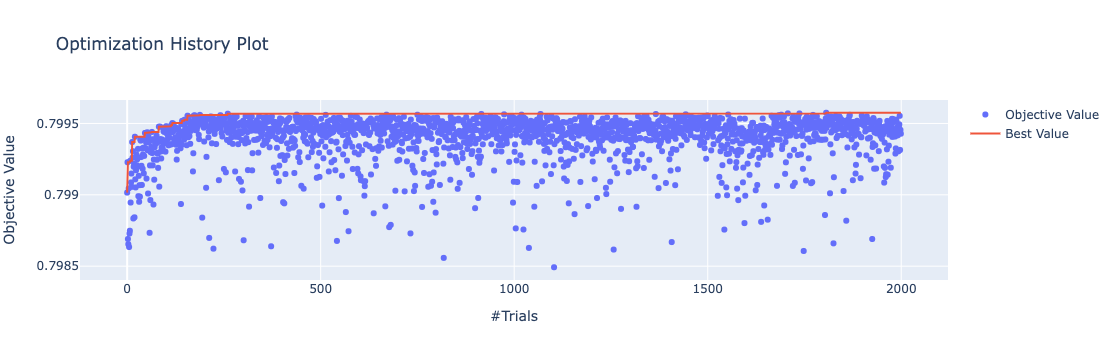

In [21]:
plot_optimization_history(study0)

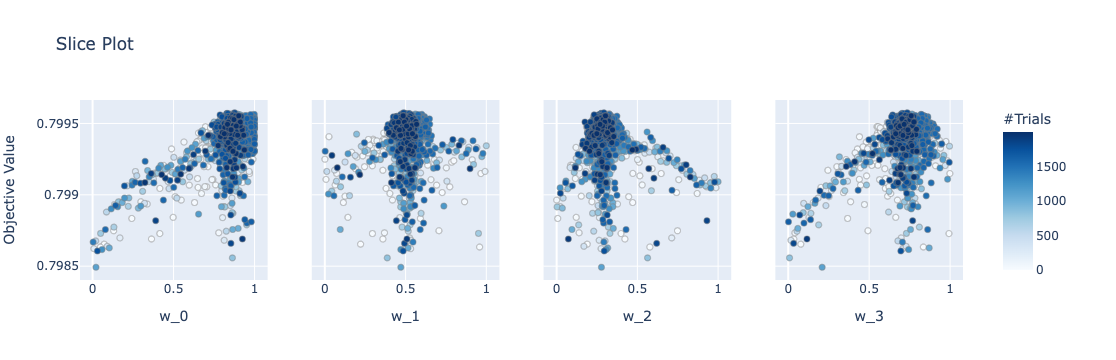

In [22]:
plot_slice(study0)

In [23]:
#plot_param_importances(study0)

In [24]:
# rank
weights0 = np.asarray([w for w in study0.best_params.values()])
weights0 /=  weights0.sum()
weights0

array([0.3666076 , 0.20394233, 0.1223111 , 0.30713898])

In [24]:
weights0 = np.asarray([w for w in study0.best_params.values()])
weights0 /=  weights0.sum()
weights0

array([0.49212252, 0.05406863, 0.18849275, 0.2653161 ])

***

In [25]:
%%time
study1 = compute_optimal_blend(all_dfs, on_cv=1, rank=True)

CPU times: user 12min 20s, sys: 324 ms, total: 12min 20s
Wall time: 13min 18s


In [26]:
print(compute_amex_metric(df1.target.values, df1.pred1.values))
print(compute_amex_metric(df2.target.values, df2.pred1.values))
print(compute_amex_metric(df4.target.values, df4.pred1.values))
print(compute_amex_metric(df5.target.values, df5.pred1.values))

0.798785434213442
0.7979806446647484
0.7963173810213919
0.7964928213424268


In [27]:
# max: 0.799888
# max: 0.800090
study1.trials_dataframe().sort_values("value", ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
233      233  0.800090 2022-08-23 22:05:55.454425 2022-08-23 22:05:55.552220   
356      356  0.800090 2022-08-23 22:06:41.425881 2022-08-23 22:06:41.531231   
1492    1492  0.800086 2022-08-23 22:14:10.652771 2022-08-23 22:14:10.800437   
1335    1335  0.800081 2022-08-23 22:13:04.428341 2022-08-23 22:13:04.597402   
1683    1683  0.800081 2022-08-23 22:15:30.700302 2022-08-23 22:15:30.827819   
1785    1785  0.800078 2022-08-23 22:16:15.167906 2022-08-23 22:16:15.347177   
416      416  0.800068 2022-08-23 22:07:03.221475 2022-08-23 22:07:03.315901   
1339    1339  0.800065 2022-08-23 22:13:06.096771 2022-08-23 22:13:06.237169   
1574    1574  0.800063 2022-08-23 22:14:44.800441 2022-08-23 22:14:44.967533   
556      556  0.800061 2022-08-23 22:07:56.050511 2022-08-23 22:07:56.199032   

                   duration  params_w_0  params_w_1  params_w_2  params_w_3  \
233  0 days 00:00:00.097795    0.540386    0.286424    0.000249    0.496208   
356  0 days 00:00:00.105350    0.540809    0.280036    0.000023    0.493446   
1492 0 days 00:00:00.147666    0.610153    0.313785    0.000204    0.548886   
1335 0 days 00:00:00.169061    0.682194    0.361183    0.000635    0.626220   
1683 0 days 00:00:00.127517    0.655932    0.348899    0.000030    0.602871   
1785 0 days 00:00:00.179271    0.699263    0.372052    0.000922    0.637701   
416  0 days 00:00:00.094426    0.612497    0.327018    0.000576    0.569193   
1339 0 days 00:00:00.140398    0.644220    0.357224    0.000062    0.598793   
1574 0 days 00:00:00.167092    0.723700    0.415691    0.000016    0.662763   
556  0 days 00:00:00.148521    0.514149    0.286382    0.000414    0.474536   

         state  
233   COMPLETE  
356   COMPLETE  
1492  COMPLETE  
1335  COMPLETE  
1683  COMPLETE  
1785  COMPLETE  
416   COMPLETE  
1339  COMPLETE  
1574  COMPLETE  
556   COMPLETE

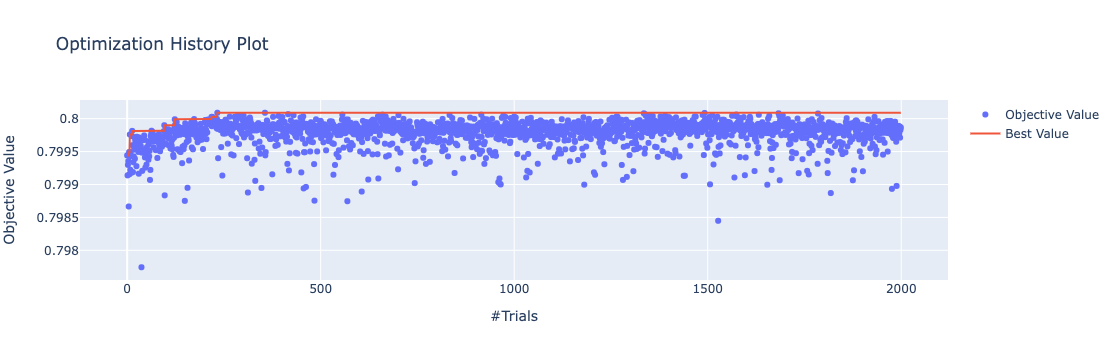

In [28]:
plot_optimization_history(study1)

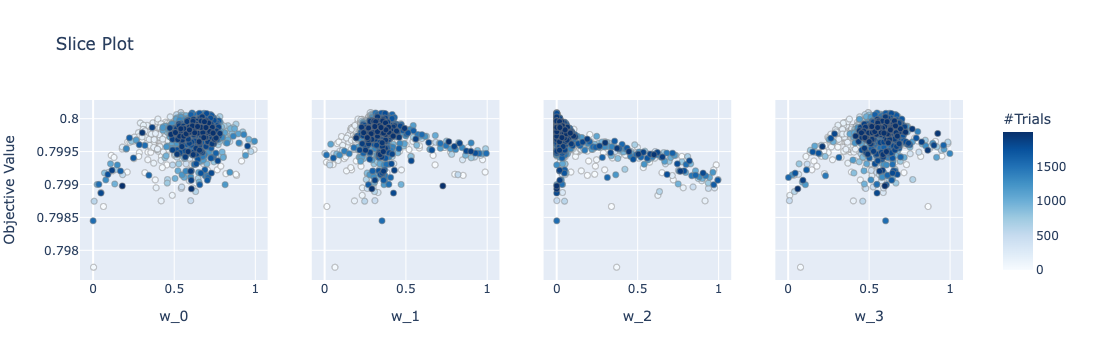

In [29]:
plot_slice(study1)

In [30]:
#plot_param_importances(study1)

In [31]:
# rank
weights1 = np.asarray([w for w in study1.best_params.values()])
weights1 /=  weights1.sum()
weights1

array([4.08372918e-01, 2.16452321e-01, 1.87955099e-04, 3.74986807e-01])

In [31]:
weights1 = np.asarray([w for w in study1.best_params.values()])
weights1 /=  weights1.sum()
weights1

array([0.24817951, 0.28048086, 0.17971606, 0.29162358])

***

In [32]:
%%time
study2 = compute_optimal_blend(all_dfs, on_cv=2, rank=True)

CPU times: user 12min 45s, sys: 396 ms, total: 12min 46s
Wall time: 13min 52s


In [33]:
print(compute_amex_metric(df1.target.values, df1.pred2.values))
print(compute_amex_metric(df2.target.values, df2.pred2.values))
print(compute_amex_metric(df4.target.values, df4.pred2.values))
print(compute_amex_metric(df5.target.values, df5.pred2.values))

0.7984374861878563
0.7978588128583453
0.79730897178247
0.7968120935308973


In [34]:
# max: 0.799853
# max: 0.799861
study2.trials_dataframe().sort_values("value", ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
1123    1123  0.799861 2022-08-23 22:25:16.199991 2022-08-23 22:25:16.354067   
242      242  0.799853 2022-08-23 22:19:21.035677 2022-08-23 22:19:21.176439   
834      834  0.799851 2022-08-23 22:23:16.274911 2022-08-23 22:23:16.447890   
1032    1032  0.799850 2022-08-23 22:24:37.929385 2022-08-23 22:24:38.060514   
244      244  0.799849 2022-08-23 22:19:21.774535 2022-08-23 22:19:22.042965   
1026    1026  0.799849 2022-08-23 22:24:35.423527 2022-08-23 22:24:35.563605   
241      241  0.799848 2022-08-23 22:19:20.661061 2022-08-23 22:19:20.767102   
464      464  0.799847 2022-08-23 22:20:48.295377 2022-08-23 22:20:48.391611   
723      723  0.799843 2022-08-23 22:22:31.328159 2022-08-23 22:22:31.447992   
1180    1180  0.799842 2022-08-23 22:25:39.950172 2022-08-23 22:25:40.143083   

                   duration  params_w_0  params_w_1  params_w_2  params_w_3  \
1123 0 days 00:00:00.154076    0.816510    0.529715    0.352450    0.898107   
242  0 days 00:00:00.140762    0.632948    0.410722    0.275929    0.694604   
834  0 days 00:00:00.172979    0.783656    0.512486    0.344382    0.880619   
1032 0 days 00:00:00.131129    0.799602    0.526924    0.296194    0.865569   
244  0 days 00:00:00.268430    0.611465    0.409748    0.235035    0.680514   
1026 0 days 00:00:00.140078    0.758640    0.500579    0.278426    0.832296   
241  0 days 00:00:00.106041    0.629442    0.417072    0.268953    0.690394   
464  0 days 00:00:00.096234    0.676788    0.449961    0.291959    0.752838   
723  0 days 00:00:00.119833    0.787767    0.519279    0.342248    0.881858   
1180 0 days 00:00:00.192911    0.803873    0.525329    0.322695    0.885511   

         state  
1123  COMPLETE  
242   COMPLETE  
834   COMPLETE  
1032  COMPLETE  
244   COMPLETE  
1026  COMPLETE  
241   COMPLETE  
464   COMPLETE  
723   COMPLETE  
1180  COMPLETE

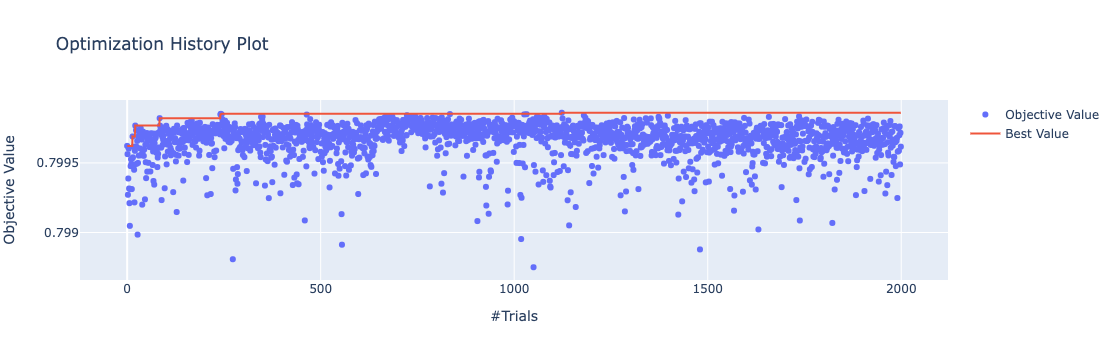

In [35]:
plot_optimization_history(study2)

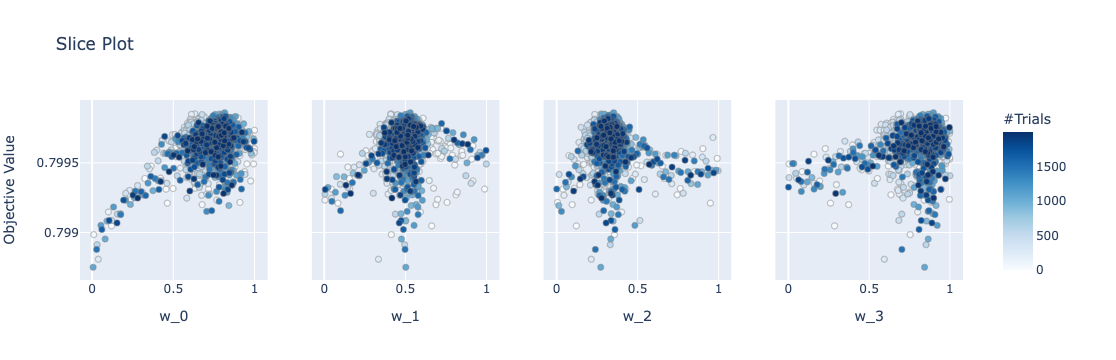

In [36]:
plot_slice(study2)

In [37]:
#plot_param_importances(study2)

In [38]:
# rank
weights2 = np.asarray([w for w in study2.best_params.values()])
weights2 /=  weights2.sum()
weights2

array([0.31443146, 0.20398892, 0.1357256 , 0.34585403])

In [38]:
weights2 = np.asarray([w for w in study2.best_params.values()])
weights2 /=  weights2.sum()
weights2

array([0.38897768, 0.1772208 , 0.14951703, 0.2842845 ])

***
## blend

In [ ]:
sub1 = pd.read_csv("../data/subs/lgbm-dart-bce-dsv06/submission-all.csv")
sub2 = pd.read_csv("../data/subs/lgbm-dart-xtree-bce-dsv06/submission-all.csv")
#sub3 = pd.read_csv("../data/subs/lgbm-dart-linear-bce-dsv06/submission-all.csv")
sub4 = pd.read_csv("../data/subs/xgboost-dsv06/submission-all.csv")
sub5 = pd.read_csv("../data/subs/catboost-dsv06/submission-all.csv")

In [ ]:
preds = np.concatenate([
    sub1.prediction.values.reshape(-1,1),
    sub2.prediction.values.reshape(-1,1),
    #sub3.prediction.values.reshape(-1,1),
    sub4.prediction.values.reshape(-1,1),
    sub5.prediction.values.reshape(-1,1)
    ],
    axis=1
)
preds

In [ ]:
sub = sub1.copy()

blend0 = (preds*weights0).sum(axis=1)
blend1 = (preds*weights1).sum(axis=1)
blend2 = (preds*weights2).sum(axis=1)

sub["prediction"] = np.mean([blend0, blend1, blend2], axis=0)

In [ ]:
sub.to_csv(SUB_PATH/"submission-blend.csv", index=False)

In [ ]:
sub.prediction.describe()

***